# Deepfake Image Detection

Autori: Bucă Mihnea-Vicențiu; Căpatână Răzvan-Nicolae; Luculescu Teodor


## Model attribution

In this part we investigate whether we can identify the generative model that has produced a particular image. We formulate this task as a multiclass classification task, where the input is an image and the output is one of the five classes: “ldm”, “lama”, “pluralistic”, “repaint”, “real”. Experiment with the same methods as for the first task. Report the overall accuracy and the per class accuracy. Display a TSNE plot of the features color coded by the five classes.

### Data

The dataset can be downloaded from [here](https://drive.google.com/file/d/1NfLX9bZtOY8dO_yj3cU7pEHGmqItqjg2/view). It contains real images from the CelebAHQ dataset and locally manipulated images produced by four generators: [LDM](https://github.com/CompVis/latent-diffusion), [Pluralistic](https://github.com/lyndonzheng/Pluralistic-Inpainting), [LAMA](https://github.com/advimman/lama), [Repaint](https://github.com/andreas128/RePaint). You can read more about how this dataset was produced in Section 3.3 of the following paper:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will extract the data for each model

In [ ]:
import zipfile
import os

# path to the zip file
zip_file_path = 'drive/MyDrive/Proiect DeepLearning/DeepFMI_local_data.zip'

# the paths to the datasets within the zip file
dataset_paths = [
    'FMI_local_data/celebhq_real_data',
    'FMI_local_data/lama',
    'FMI_local_data/ldm',
    'FMI_local_data/pluralistic',
    'FMI_local_data/repaint'
]

# create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Iterate through the dataset paths
    for dataset_path in dataset_paths:
         zip_ref.extractall(members=[
            name for name in zip_ref.namelist()
            if name.startswith(dataset_path)
        ], path='/content/')  # Extract to the '/content/' directory


## Training Models

In [ ]:
# important libraries
import torch
import glob
import pandas as pd
import torch.nn as nn
import torch.optim as optim

import numpy as np

import timm
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import display, Markdown
from sklearn.metrics import average_precision_score
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
from PIL import Image
from tqdm import tqdm  # for progress bar

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import h5py

In [ ]:
class DeepFakeDataset(Dataset):
    """
    Takes a folder of real images and a list of folders of fake images and assigns labels (0 for real, 1/2/3/4 for each fake image).
    0 = real
    1 = lama
    2 = ldm
    3 = repaint
    4 = pluralistic
    """
    def __init__(self, real_folder: str, fake_folders: list[str], transform=None):
        # grab all .png under each
        self.real_paths = sorted(glob.glob(os.path.join(real_folder, '*.png')))
        self.samples = [(p, 0) for p in self.real_paths]

        self.fake_paths = []
        for label, fake_folder in enumerate(fake_folders):
            current_fake_paths = sorted(glob.glob(os.path.join(fake_folder, '*.png')))
            self.fake_paths += current_fake_paths
            self.samples += [(p, label + 1) for p in current_fake_paths]

        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
def make_model_dataloaders(
    root_dir: str,            # contains subfolders: lama/, ldm/, repaint/, pluralistic/
    real_root: str,           # path to celebhq_real_data
    model_names: list[str],   # ['lama','ldm','repaint','pluralistic']
    splits: list[str] = ('train','valid','test'),
    batch_size: int = 16,
    img_size: int = 256,
    num_workers: int = 2
):
    """
    Returns a dict:
      { split: DataLoader, … }
      Each loader mixes real vs models' fake images.
    """

    # strong augmentation for train
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
    ])

    # weak augmentation for val/test
    test_tf = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
    ])

    dataloaders = {}
    for split in splits:
        real_folder = os.path.join(real_root, split)
        fake_folders = [os.path.join(root_dir, model_name, split) for model_name in model_names]

        tf = train_tf if split=='train' else test_tf
        ds = DeepFakeDataset(real_folder, fake_folders, transform=tf)

        dataloaders[split] = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=(split=='train'),
            num_workers=num_workers,
            pin_memory=True
        )

    return dataloaders

In [ ]:
root = "/content/FMI_local_data"
deepfake_models = ["lama", "ldm", "repaint", "pluralistic"]
loaders = make_model_dataloaders(
    root_dir=root,
    real_root=os.path.join(root, "celebhq_real_data"),
    model_names=deepfake_models,
    splits=['train', 'valid', 'test'],
    batch_size=16,
    img_size=256,
    num_workers=2
)

# test
train_loader = loaders['train']
print(f"train batches: {len(train_loader)}")

train batches: 2813


In [ ]:
import gc
def train_timm_scratch(
    dataloaders: dict,
    model_name: str = 'xception41',
    model: torch.nn.Module = None,
    num_classes: int = 5,
    lr: float = 1e-3,
    num_epochs: int = 5,
    device: str = None
):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n=== Training {model_name} from scratch for {num_epochs} epochs on {device} ===")

    # instantiate model if not provided
    if model is None:
        model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    model = model.to(device)

    # loss & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    label_to_model = {
        0: 'real',  1: 'lama', 2: 'ldm',
        3: 'repaint', 4: 'pluralistic'
    }

    history = {'train_loss': [], 'train_acc': [], 'valid_acc': []}

    # --- training loop ---
    for epoch in range(1, num_epochs+1):
        print(f"\n--- Epoch {epoch}/{num_epochs} ---")
        # train
        model.train()
        running_loss = 0.0
        train_label_cnts = [0]*num_classes
        train_accs       = [0]*num_classes

        for imgs, labels in dataloaders['train']:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss   = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            bs = imgs.size(0)
            running_loss += loss.item()*bs
            preds = logits.argmax(dim=1)
            for p, t in zip(preds, labels):
                ti = t.item()
                train_label_cnts[ti] += 1
                if p.item()==ti:
                    train_accs[ti] += 1

        avg_loss = running_loss / len(dataloaders['train'].dataset)
        total_correct = sum(train_accs)
        total_seen    = sum(train_label_cnts)
        train_acc     = total_correct / total_seen
        history['train_loss'].append(avg_loss)
        history['train_acc'].append(train_acc)

        print(f" Train: loss={avg_loss:.4f}, acc={train_acc:.4%}")
        for i in range(num_classes):
            cnt = train_label_cnts[i]
            acc = train_accs[i]/cnt if cnt else 0.0
            print(f"   {label_to_model[i]:12s}: {acc:.4%} ({cnt})")

        # validate (accuracy only)
        model.eval()
        total_correct = total_seen = 0
        valid_label_cnts = [0]*num_classes
        valid_accs       = [0]*num_classes

        with torch.no_grad():
            for imgs, labels in dataloaders['valid']:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(dim=1)
                total_correct += (preds==labels).sum().item()
                total_seen    += labels.size(0)
                for p, t in zip(preds, labels):
                    ti = t.item()
                    valid_label_cnts[ti] += 1
                    if p.item()==ti:
                        valid_accs[ti] += 1

        valid_acc = total_correct / total_seen
        history['valid_acc'].append(valid_acc)
        print(f" Valid: acc={valid_acc:.4%}")
        for i in range(num_classes):
            cnt = valid_label_cnts[i]
            acc = valid_accs[i]/cnt if cnt else 0.0
            print(f"   {label_to_model[i]:12s}: {acc:.4%} ({cnt})")

    # --- final feature extraction ---
    model.eval()
    valid_features = []
    valid_labels   = []
    with torch.no_grad():
        for imgs, labels in dataloaders['valid']:
            imgs = imgs.to(device)
            # extract penultimate features
            feats = model.forward_features(imgs)
            valid_features.append(feats.cpu())
            valid_labels.append(labels)

    valid_features = torch.cat(valid_features, dim=0).numpy()
    valid_labels   = torch.cat(valid_labels,   dim=0).numpy()

    # clean up
    torch.cuda.empty_cache()
    gc.collect()

    # package everything in a single dict
    results = {
        'model_state_dic':           model.state_dict(),
        'history':         history,
        'valid_features':  valid_features,
        'valid_labels':    valid_labels
    }
    return results

In [ ]:
results = train_timm_scratch(
    dataloaders=loaders,
    model_name='xception41',
    num_classes=5,
    lr=1e-3,
    num_epochs=5
)


=== Training xception41 from scratch for 5 epochs on cuda ===

--- Epoch 1/5 ---
 Train: loss=1.6111, acc=23.1472%
   real        : 23.7111% (9000)
   lama        : 12.7444% (9000)
   ldm         : 14.7222% (9000)
   repaint     : 14.1127% (8999)
   pluralistic : 50.4444% (9000)
 Valid: acc=22.3556%
   real        : 93.3333% (900)
   lama        : 0.0000% (900)
   ldm         : 3.6667% (900)
   repaint     : 3.1111% (900)
   pluralistic : 11.6667% (900)

--- Epoch 2/5 ---
 Train: loss=1.5857, acc=25.2117%
   real        : 27.3667% (9000)
   lama        : 5.3556% (9000)
   ldm         : 14.2222% (9000)
   repaint     : 11.8013% (8999)
   pluralistic : 67.3111% (9000)
 Valid: acc=21.2889%
   real        : 0.0000% (900)
   lama        : 0.0000% (900)
   ldm         : 97.8889% (900)
   repaint     : 0.0000% (900)
   pluralistic : 8.5556% (900)

--- Epoch 3/5 ---
 Train: loss=1.5813, acc=25.5072%
   real        : 35.4778% (9000)
   lama        : 7.8889% (9000)
   ldm         : 10.8889% (90

In [ ]:
save_path = '/content/Task-2/First-Method/results.pth'

save_path_dir = '/content/Task-2/First-Method'
os.makedirs(save_path_dir, exist_ok=True)  # Ensure the directory exists

In [ ]:

import os
# save models in local
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure the directory exists
torch.save(results['model_state_dic'], save_path)
print(f"Results saved to: {save_path}")


Results saved to: /content/Task-2/First-Method/results.pth


In [ ]:
def plot_tsne(features, labels, num_classes=5):
  tsne = TSNE(n_components=2, random_state=17, perplexity=30)
  tsne_features = tsne.fit_transform(features)

  plt.figure(figsize=(10, 8))

  label_to_model = {
      0: 'real',
      1: 'lama',
      2: 'ldm',
      3: 'repaint',
      4: 'pluralistic'
  }

  label_to_color = {
      0: 'green',
      1: 'red',
      2: 'blue',
      3: 'yellow',
      4: 'purple'
  }

  for label in range(num_classes):
    mask = labels == label

    plt.scatter(
        tsne_features[mask, 0],
        tsne_features[mask, 1],
        color=label_to_color[label],
        label=label_to_model[label], alpha=0.5
    )

  plt.legend()
  plt.title('TSNE Plot of Features')
  plt.xlabel('1st Dimension')
  plt.ylabel('2nd Dimension')
#   plt.grid(False)
  plt.show()

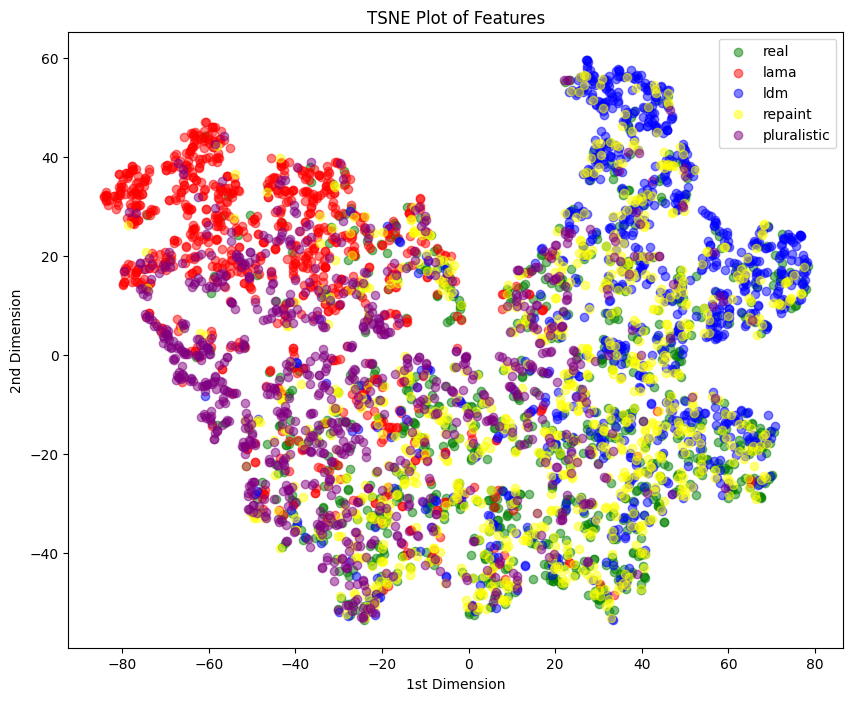

In [ ]:
# print(results['valid_features'].shape)

plot_tsne(results['valid_features'].mean(axis=(2, 3)), results['valid_labels'])